# Decoding a TFRecord file from the ImageNet dataset

In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.config.experimental.set_visible_devices([], 'GPU') # force CPU usage
tf.version.VERSION

'2.5.0'

In [2]:
pattern = '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/*'
list_of_files = sorted(glob.glob(pattern))
list_of_files[:3], len(list_of_files)

(['/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00000-of-00128',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00001-of-00128',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00002-of-00128'],
 128)

In [3]:
d = tf.data.Dataset.list_files(list_of_files, shuffle=False)

print(d.cardinality().numpy())

# for i, file in enumerate(d):
#     print(file)
#     if i >= 2:
#         break

128


In [4]:
d = tf.data.Dataset.list_files(pattern, shuffle=True, seed=None)

print(d.cardinality().numpy())

for i, file in enumerate(d):
    print(file)
    if i >= 2:
        break

128
tf.Tensor(b'/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00081-of-00128', shape=(), dtype=string)
tf.Tensor(b'/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00105-of-00128', shape=(), dtype=string)
tf.Tensor(b'/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00086-of-00128', shape=(), dtype=string)


# How can we split the data across the nodes?

In [5]:
num_nodes = 32
node_id = 14  # [0-31]

## A simple way is to use array slices
list_of_files[node_id::num_nodes]

['/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00014-of-00128',
 '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00046-of-00128',
 '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00078-of-00128',
 '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00110-of-00128']

The recommended way it use tf.data.Dataset.shard()<br>
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shard

In [6]:
d = tf.data.Dataset.list_files(pattern, shuffle=False)
d = d.shard(num_shards=num_nodes, index=node_id)

print(d.cardinality().numpy())

for f in d: print(f)

4
tf.Tensor(b'/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00014-of-00128', shape=(), dtype=string)
tf.Tensor(b'/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00046-of-00128', shape=(), dtype=string)
tf.Tensor(b'/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00078-of-00128', shape=(), dtype=string)
tf.Tensor(b'/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00110-of-00128', shape=(), dtype=string)


In [7]:
for f in d: print(f)

tf.Tensor(b'/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00014-of-00128', shape=(), dtype=string)
tf.Tensor(b'/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00046-of-00128', shape=(), dtype=string)
tf.Tensor(b'/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00078-of-00128', shape=(), dtype=string)
tf.Tensor(b'/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00110-of-00128', shape=(), dtype=string)


In [8]:
image_shape = (360, 360)
AUTO = tf.data.experimental.AUTOTUNE

def decode_n_resize(serialized_example):
    features = tf.io.parse_single_example(
        serialized_example,
        features={
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        })
    image = tf.image.decode_jpeg(features['image/encoded'], channels=3)
    image = tf.image.resize_with_crop_or_pad(image, *image_shape)
    label = tf.cast(features['image/class/label'], tf.int64) - 1  # [0-999]
    return image, label

<br>
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#interleave

In [9]:
d = tf.data.Dataset.list_files(pattern, shuffle=False)
d = d.shard(num_shards=num_nodes, index=node_id)
d = d.interleave(tf.data.TFRecordDataset, cycle_length=4, block_length=1, num_parallel_calls=AUTO)
d = d.map(decode_n_resize, num_parallel_calls=AUTO)

image, label = next(iter( d ))
print('Image shape:', image.shape, 'Labels:', label.numpy())

Image shape: (360, 360, 3) Labels: 970


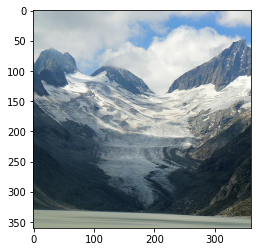

In [10]:
plt.imshow(image)
plt.show()

In [11]:
print(d.cardinality().numpy())

# INFINITE_CARDINALITY 	-1
# UNKNOWN_CARDINALITY 	-2

-2


In [12]:
%%time

for i, data in enumerate(d): pass  # WARNING: This actually loads all 1/num_nodes images from SCRATCH

print(i)

1563
CPU times: user 6.03 s, sys: 193 ms, total: 6.23 s
Wall time: 657 ms


In [13]:
d = d.cache()   # cache resized images

In [14]:
%%time

for i, data in enumerate(d): pass  # WARNING: This actually loads all 1/num_nodes images from SCRATCH

print(i)

1563
CPU times: user 6.03 s, sys: 364 ms, total: 6.4 s
Wall time: 685 ms


In [15]:
print(f'Cache uses {(np.prod(image.shape)*i) / 1024**3 :.2f}GB of RAM')

Cache uses 0.57GB of RAM


# What happens if nodes have different amount of images?